## **데이터셋 불러오기**

In [ ]:
from google.colab import files
files.upload()  # kaggle.json 업로드 창 표시
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download pratik2901/multiclass-weather-dataset

Dataset URL: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/91.4M [00:00<?, ?B/s]
100% 91.4M/91.4M [00:00<00:00, 1.39GB/s]


## **날씨이미지 데이터셋 전처리**

압축해제, 폴더분리, 카테고리별 데이터 분리(train/test)

In [ ]:
import os
import zipfile
import random
from shutil import copyfile, rmtree   # copyfile: 파일 복사, rmtree: 폴더 전체 삭제


# 파일 및 경로 설정
zip_file = 'multiclass-weather-dataset.zip'
train_dir = './train'
test_dir = './test'
base_dir = '/content/Multi-class Weather Dataset'
categories = ['Cloudy', 'Rain', 'Shine', 'Sunrise']


# 1. 압축 해제
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('.')


# 2. 기존 폴더가 있다면 삭제 (재실행 대비)
if os.path.exists(train_dir):
    rmtree(train_dir)
if os.path.exists(test_dir):
    rmtree(test_dir)

# 3. 새 폴더 구조 생성
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# 각 카테고리별 데이터 파일 나누기
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)


# 4. 각 카테고리별 이미지 파일을 train/test로 분리 (8:2 비율)
for category in categories:
    category_path = os.path.join(base_dir, category)
    files = os.listdir(category_path)  # 해당 카테고리의 모든 파일 목록
    random.shuffle(files)                   # 파일 순서를 무작위로 섞기

    split_idx = int(len(files)*.8)          # 80% → train, 20% → test
    train_files = files[:split_idx]
    test_files = files[split_idx:]

    # 학습용 데이터 복사
    for file in train_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(train_dir, category, file)
        copyfile(src, dst)                       # src에서 dst로 복사

    # 테스트용 데이터 복사
    for file in test_files:
        src = os.path.join(category_path, file)
        dst = os.path.join(test_dir, category, file)
        copyfile(src, dst)

print("데이터 분리가 완료되었습니다.")

데이터 분리가 완료되었습니다.


In [ ]:
import torch
import time
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

## **전처리, 분할, 데이터로더 구성**

In [ ]:
# 1. 이미지 전처리 정의
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),  # 데이터 증강 (학습용만 적용)
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])


# 2. 학습용 데이터셋 로드 및 train/val 분할
full_train_dataset = datasets.ImageFolder(root = 'train/', transform = transform_train)
dataset_size = len(full_train_dataset)
train_size = int(dataset_size*0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
print(len(train_dataset), len(val_dataset))


# 3. 테스트 데이터셋 로드
test_dataset = datasets.ImageFolder(root = 'test/', transform = transform_test)


# 4. DataLoader 구성
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

719 180


## **이미지 시각화 및 라벨 출력**

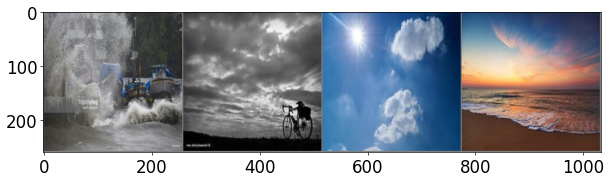

Labels: ['Rain', 'Cloudy', 'Shine', 'Sunrise']


In [ ]:
# 1. 플롯 설정
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


# 2. 이미지 시각화 함수 정의
def imshow(input):
    input = input.numpy().transpose((1, 2, 0))  # CxHxW → HxWxC
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean                           # 역정규화
    input = np.clip(input, 0, 1)                           # 값 범위 제한
    plt.imshow(input)
    plt.show()


# 3. 클래스 이름 정의
class_names = {
    0:"Cloudy",
    1:"Rain",
    2:"Shine",
    3:"Sunrise"
}


# 4. 학습 데이터 배치에서 이미지 시각화
iterator = iter(train_dataloader)
imgs, labels = next(iterator)

# 이미지 4장 격자 형태로 시각화
grid_img = make_grid(imgs[:4])
imshow(grid_img)


# 5. 해당 이미지들의 클래스 라벨 출력
label_names = [class_names[labels[i].item()] for i in range(4)]
print("Labels:", label_names)

## **다양한 모델 만들기**

In [ ]:
# 단층 완전연결 이미지 분류 모델 (Model1)

class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()

        # 이미지(256x256 RGB)를 1차원 벡터로 flatten한 후 → 4개의 클래스로 분류
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(256 * 256 * 3, 4)  # 출력: [Cloudy, Rain, Shine, Sunrise]


    def forward(self, x):
        x = self.flatten(x)  # 입력: [B, 3, 256, 256] → [B, 196608]
        x = self.linear1(x)  # 완전 연결층: [B, 196608] → [B, 4]
        return x                 # 출력: 클래스별 로짓

In [ ]:
# 2층 완전연결 신경망 모델 (Model2)

class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()

        self.flatten = nn.Flatten()                            # 이미지 → 1차원 벡터
        self.linear1 = nn.Linear(256 * 256 * 3, 64)  # 입력 벡터 → 은닉층 64차원
        self.linear2 = nn.Linear(64, 4)                     # 은닉층 → 4개 클래스 점수 (logits)



    def forward(self, x): # x: 이미지
        x = self.flatten(x)  # [B, 3, 256, 256] → [B, 196608]
        x = self.linear1(x)  # [B, 196608] → [B, 64]
        x = self.linear2(x)  # [B, 64] → [B, 4]
        return x

In [ ]:
class Model3(nn.Module):
    def __init__(self):
        super(Model3, self).__init__()

        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(256 * 256 * 3, 128)  # 입력 → 128차원
        self.dropout1 = nn.Dropout(0.5)                  # 과적합 방지

        self.linear2 = nn.Linear(128, 64)                   # 128 → 64
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(64, 32)                     # 64 → 32
        self.dropout3 = nn.Dropout(0.5)

        self.linear4 = nn.Linear(32, 4)                        # 출력: 4개 클래스 (Cloudy, Rain, Shine, Sunrise)


    def forward(self, x):
        x = self.flatten(x)             # [B, 3, 256, 256] → [B, 196608]

        x = F.relu(self.linear1(x))
        x = self.dropout1(x)

        x = F.relu(self.linear2(x))
        x = self.dropout2(x)

        x = F.relu(self.linear3(x))
        x = self.dropout3(x)

        x = self.linear4(x)             # [B, 4]
        return x

In [ ]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch+1} - Training]')

    model.train()  # 모델을 학습 모드로 전환
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        # 순전파
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 통계 누적
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        # 로그 출력 (log_step마다)
        if i  % log_step == 0:
            avg_loss = running_loss / total
            avg_acc = running_corrects.double() / total
            print(f'[Batch {i + 1}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')

    # 에폭 요약 출력
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'[Epoch Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print("Elapsed time:", time.time() - start_time)

    return epoch_loss, epoch_acc.item()

In [ ]:
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')

    model.eval()  # 평가 모드 (Dropout, BatchNorm 비활성화)
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():  # 그래디언트 계산 비활성화
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # 통계 누적
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        # log_step마다 중간 결과 출력
        if i % log_step == 0:
            avg_loss = running_loss / total
            avg_acc = running_corrects.double() / total
            print(f'[Batch {i + 1}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')

    # 에폭 단위 결과 출력
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    print(f'[Validation Summary] Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    print("Elapsed time:", time.time() - start_time)

    return epoch_loss, epoch_acc.item()

In [ ]:
def test():
    start_time = time.time()
    print(f'[Test]')

    model.eval()  # 평가 모드 (Dropout, BatchNorm 비활성화)
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():  # 테스트 시 gradient 계산 비활성화
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        # 통계 누적
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        # log_step마다 중간 결과 출력
        if i % log_step == 0:
            avg_loss = running_loss / total
            avg_acc = running_corrects.double() / total
            print(f'[Batch {i + 1}] Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}')

    # 테스트 전체 결과 출력
    test_loss = running_loss / total
    test_acc = running_corrects.double() / total
    print(f'[Test Summary] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}')
    print("Elapsed time:", time.time() - start_time)

    return test_loss, test_acc.item()


In [ ]:
# 에폭에 따른 학습률 조정 함수

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate

    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10  # 결과적으로 원래 lr의 1/100

    # 옵티마이저 내 모든 파라미터 그룹에 학습률 적용
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Model1

In [ ]:
# 1. 하이퍼파라미터 및 설정
learning_rate = 0.01
log_step = 8
num_epochs = 20


# 2. 모델 생성 및 설정
model = Model1()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


# 3. 학습 이력 및 최고 성능 기록 초기화
best_val_acc = 0
best_epoch = 0
history = []
accuracy = []


# 4. 체크포인트 디렉토리 생성
os.makedirs("weights/Model1", exist_ok=True)


# 5. 학습 루프
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    # 최적 모델 저장
    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model1/best_checkpoint_epoch_{epoch + 1}.pth")

# 마지막 에폭 모델 저장
torch.save(model.state_dict(), f"weights/Model1/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch 1] Loss: 0.0220, Accuracy: 0.2031
[Batch 9] Loss: 0.2137, Accuracy: 0.6354
[Epoch Summary] Loss: 0.2493, Accuracy: 0.6551
Elapsed time: 4.822608947753906
[Epoch: 1 - Validation]
[Batch 1] Loss: 0.3245, Accuracy: 0.6250
[Validation Summary] Loss: 0.3719, Accuracy: 0.5944
Elapsed time: 1.2893953323364258
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch 1] Loss: 0.1426, Accuracy: 0.7500
[Batch 9] Loss: 0.2707, Accuracy: 0.7083
[Epoch Summary] Loss: 0.3116, Accuracy: 0.6968
Elapsed time: 4.678953409194946
[Epoch: 2 - Validation]
[Batch 1] Loss: 0.4146, Accuracy: 0.6875
[Validation Summary] Loss: 0.4104, Accuracy: 0.6833
Elapsed time: 1.0601661205291748
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch 1] Loss: 0.1928, Accuracy: 0.7812
[Batch 9] Loss: 0.2828, Accuracy: 0.7483
[Epoch Summary] Loss: 0.2676, Accuracy: 0.7441
Elapsed time: 4.2082719802856445
[Epoch: 3 - Validation]
[Batch 1] Loss: 0.2991, Accuracy: 0.6719
[Validation Summary

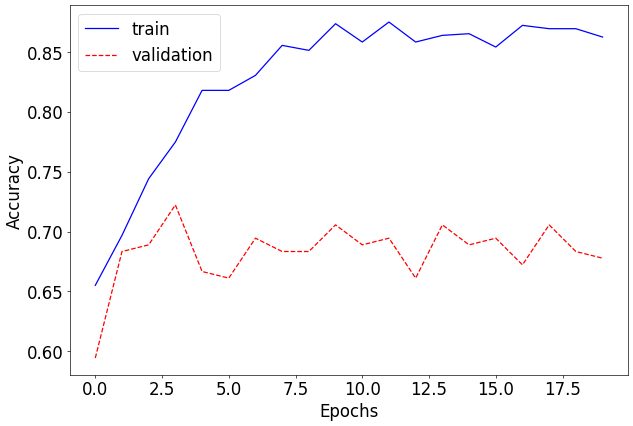

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch 1] Loss: 0.2437, Accuracy: 0.5469
[Test Summary] Loss: 0.1568, Accuracy: 0.7257
Elapsed time: 2.379117488861084
Test loss: 0.15684038
Test accuracy: 72.57%


Model2

In [ ]:
# 1. 체크포인트 저장 경로 생성
os.makedirs("weights/Model2", exist_ok=True)


# 2. 하이퍼파라미터 설정
learning_rate = 0.01
log_step = 8
num_epochs = 20


# 3. 모델, 손실 함수, 옵티마이저 설정
model = Model2()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


# 4. 학습 이력 및 최고 정확도 초기화
best_val_acc = 0
best_epoch = 0
history = []
accuracy = []


# 5. 학습 루프 시작
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))


    # 6. 최고의 모델 저장
    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model2/best_checkpoint_epoch_{epoch + 1}.pth")


# 7. 마지막 에폭 모델 저장
torch.save(model.state_dict(), f"weights/Model2/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch 1] Loss: 0.0223, Accuracy: 0.2500
[Batch 9] Loss: 0.0743, Accuracy: 0.5104
[Epoch Summary] Loss: 0.1017, Accuracy: 0.5229
Elapsed time: 4.9530699253082275
[Epoch: 1 - Validation]
[Batch 1] Loss: 0.2606, Accuracy: 0.5625
[Validation Summary] Loss: 0.3547, Accuracy: 0.5278
Elapsed time: 1.0430073738098145
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch 1] Loss: 0.2806, Accuracy: 0.5000
[Batch 9] Loss: 0.1600, Accuracy: 0.4983
[Epoch Summary] Loss: 0.1644, Accuracy: 0.5229
Elapsed time: 4.177818536758423
[Epoch: 2 - Validation]
[Batch 1] Loss: 0.3744, Accuracy: 0.6250
[Validation Summary] Loss: 0.2117, Accuracy: 0.6389
Elapsed time: 1.0498859882354736
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch 1] Loss: 0.1990, Accuracy: 0.6562
[Batch 9] Loss: 0.1935, Accuracy: 0.5712
[Epoch Summary] Loss: 0.2385, Accuracy: 0.5883
Elapsed time: 4.84635066986084
[Epoch: 3 - Validation]
[Batch 1] Loss: 0.6007, Accuracy: 0.5938
[Validation Summary]

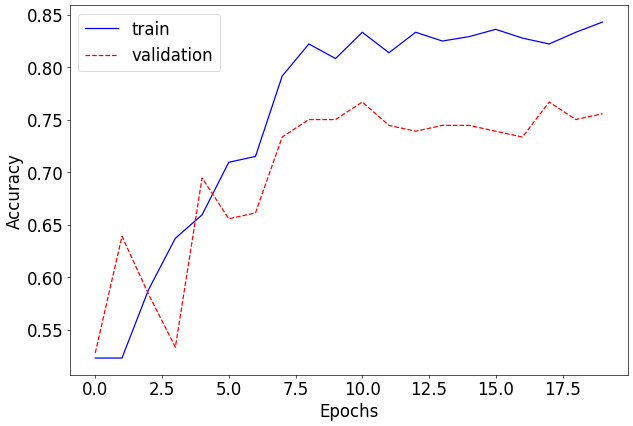

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch 1] Loss: 0.0235, Accuracy: 0.6094
[Test Summary] Loss: 0.0206, Accuracy: 0.7699
Elapsed time: 2.964026689529419
Test loss: 0.02062651
Test accuracy: 76.99%


Model3

In [ ]:
# 1. 체크포인트 저장 경로 생성
os.makedirs("weights/Model3", exist_ok=True)


# 2. 하이퍼파라미터 설정
learning_rate = 0.01
log_step = 20
num_epochs = 20


# 3. 모델 및 학습 도구 설정
model = Model3()
model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)


# 4. 이력 및 최고 성능 기록 초기화
best_val_acc = 0
best_epoch = 0
history = []
accuracy = []


# 5. 학습 루프
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)

    train_loss, train_acc = train()
    val_loss, val_acc = validate()

    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))


    # 6. 최적 모델 저장
    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f"weights/Model3/best_checkpoint_epoch_{epoch + 1}.pth")


# 7. 마지막 에폭 모델 저장
torch.save(model.state_dict(), f"weights/Model3/last_checkpoint_epoch_{num_epochs}.pth")

[Epoch: 1 - Training]
[Batch 1] Loss: 0.0215, Accuracy: 0.1719
[Epoch Summary] Loss: 0.0204, Accuracy: 0.3853
Elapsed time: 4.359562873840332
[Epoch: 1 - Validation]
[Batch 1] Loss: 0.0148, Accuracy: 0.5938
[Validation Summary] Loss: 0.0146, Accuracy: 0.6611
Elapsed time: 1.0593056678771973
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch 1] Loss: 0.0179, Accuracy: 0.5000
[Epoch Summary] Loss: 0.0177, Accuracy: 0.5438
Elapsed time: 4.812493562698364
[Epoch: 2 - Validation]
[Batch 1] Loss: 0.0133, Accuracy: 0.6406
[Validation Summary] Loss: 0.0126, Accuracy: 0.6778
Elapsed time: 1.1993815898895264
[Info] best validation accuracy!
[Epoch: 3 - Training]
[Batch 1] Loss: 0.0159, Accuracy: 0.5781
[Epoch Summary] Loss: 0.0159, Accuracy: 0.5855
Elapsed time: 4.262139797210693
[Epoch: 3 - Validation]
[Batch 1] Loss: 0.0125, Accuracy: 0.6406
[Validation Summary] Loss: 0.0124, Accuracy: 0.7056
Elapsed time: 1.0765819549560547
[Info] best validation accuracy!
[Epoch: 4 - Training]
[Ba

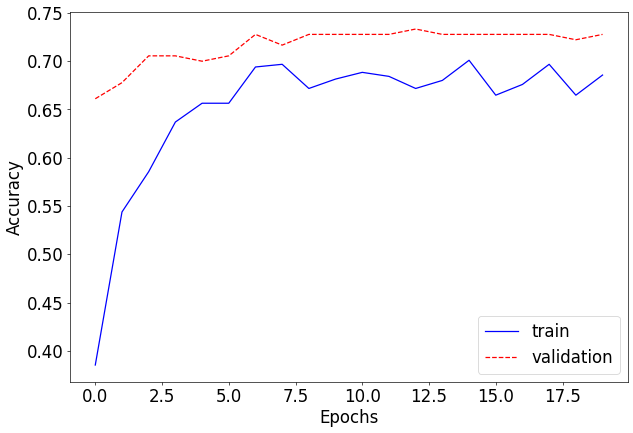

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch 1] Loss: 0.0174, Accuracy: 0.5469
[Test Summary] Loss: 0.0112, Accuracy: 0.7301
Elapsed time: 3.0923640727996826
Test loss: 0.01123914
Test accuracy: 73.01%
